In [399]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [400]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
# 'cuda' if torch.cuda.is_available else
device

device(type='cuda')

In [401]:
sns.set_style('white')

In [402]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()


In [403]:
experiment = 0

In [404]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [405]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

In [406]:
seq_len = 2
n_seq = 11
batch_size = 6

In [407]:
import numpy as np

In [408]:
df = pd.read_csv('../data/interpolated_spectra.csv')
df = df.dropna()
df
# axes = plt.plot(df['Wavelength'], df['Flux'])

,Galaxy1_Interpolated_Wavelength,Galaxy1_Interpolated_Flux,Galaxy2_Interpolated_Flux,Galaxy3_Interpolated_Flux,Galaxy4_Interpolated_Flux,Galaxy5_Interpolated_Flux,Galaxy6_Interpolated_Flux,Galaxy7_Interpolated_Flux,Galaxy8_Interpolated_Flux,Galaxy9_Interpolated_Flux,Galaxy10_Interpolated_Flux
0,-0.842943,0.746866,-3.648556,0.962676,2.343940,0.932520,1.959183,1.600908,0.870846,-1.010272,-2.845289
1,-0.705645,0.842544,-3.581693,1.614637,2.409745,1.007313,1.956706,1.708686,1.216199,-0.947637,-2.848671
2,-0.592377,0.987641,-3.522940,1.965995,2.468346,1.075428,2.028853,1.890359,1.585367,-0.889690,-2.752586
3,-0.531998,1.131349,-3.491732,2.235187,2.499595,1.119627,2.093698,2.053672,1.860498,-0.857481,-2.682146
4,-0.380788,1.552895,-3.404935,2.786062,2.588616,1.262114,2.404241,2.506013,2.475953,-0.756895,-2.365389
5,-0.260371,1.824945,-3.335526,3.154547,2.658226,1.405688,2.593897,2.802265,2.927917,-0.680074,-2.168904
6,-0.144375,1.936601,-3.188655,3.309351,2.722790,1.507944,2.671673,2.930389,3.174421,-0.615528,-1.978550
7,0.072263,1.985986,-1.748981,3.421195,2.885237,1.653866,2.692104,3.038744,3.419593,-0.470417,0.194109
8,0.174938,2.000104,-1.117579,3.519785,3.022564,1.742424,2.695281,3.217830,3.499660,-0.365788,1.071467
9,0.275376,1.944683,-0.691794,3.646233,3.240423,1.863719,2.641478,3.495863,3.480806,-0.199834,1.661115


In [409]:
len(df)

17

In [410]:
# len_col = len(df.columns)
# # Generate column names
# column_names = [f'galaxy {i+1}' for i in range(len_col)]

# # Assign column names to the DataFrame
# df.columns = column_names

In [411]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values).astype(np.float32)
len(scaled_data)


17

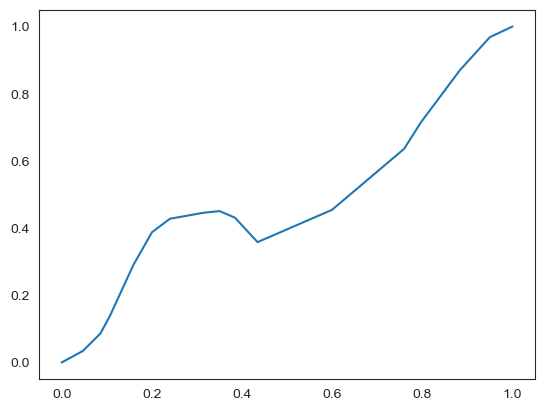

In [412]:
sc = pd.DataFrame(scaled_data)
plt.plot(sc[0], sc[1])

In [413]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[1:])
# data.append(scaled_data[1])
n_windows = len(data)
print(data)

[array([[0.0472209 , 0.03440475, 0.01502013, 0.18777682, 0.02741904,
        0.03121711, 0.        , 0.03568542, 0.07514964, 0.02641621,
        0.        ],
       [0.08617698, 0.08658049, 0.02821868, 0.28897417, 0.05183608,
        0.05964702, 0.02634075, 0.09583781, 0.15548174, 0.05085525,
        0.01800392],
       [0.10694317, 0.13825676, 0.03522919, 0.36650637, 0.06485669,
        0.07809484, 0.05001549, 0.14991109, 0.21535085, 0.06443921,
        0.03120251],
       [0.15894862, 0.2898414 , 0.05472745, 0.5251684 , 0.10194869,
        0.13756597, 0.16339432, 0.29968217, 0.34927562, 0.10686114,
        0.0905548 ],
       [0.20036332, 0.38766834, 0.07031962, 0.63129866, 0.13095294,
        0.19749056, 0.23263715, 0.39777187, 0.44762412, 0.13926007,
        0.12737098],
       [0.24025774, 0.42781866, 0.10331313, 0.6758851 , 0.15785427,
        0.24017023, 0.26103303, 0.4401938 , 0.501264  , 0.16648194,
        0.16303863],
       [0.31476554, 0.44557744, 0.42672464, 0.7080981 , 0

In [414]:
# np.isnan(data).any(), np.isinf(data).any()

In [415]:
from torch.utils.data import Dataset, DataLoader

In [416]:
# prompt: I want you to use scaled data and create a dataloader of size (batch, seq_len, 1) and then make the same for random number

import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len + 1

    def __getitem__(self, index):
        return self.data[index:index + self.seq_len]


# Create dataset and dataloader for scaled data
dataset = TimeSeriesDataset(scaled_data, seq_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
real_batch = dataloader
# Create random data and dataloader
random_data = torch.randn(len(scaled_data), 11).float()
random_dataset = TimeSeriesDataset(random_data, seq_len)
random_dataloader = DataLoader(random_dataset, batch_size=batch_size, shuffle=True)
random_batch = random_dataloader
# Example usage
for batch in dataloader:
    print(batch.shape)  # Should be (batch_size, seq_len, 1)
    break

for batch in random_dataloader:
    print(batch.shape) # Should be (batch_size, seq_len, 1)
    break


torch.Size([6, 2, 11])
torch.Size([6, 2, 11])


In [417]:
hidden_dim = 11
num_layers = 128

In [418]:
from torch.utils.tensorboard import SummaryWriter

In [419]:
writer = SummaryWriter(log_dir.as_posix())

In [420]:
import torch
import torch.nn as nn

# RNN block generator

In [421]:
# Define the model building block: A recurrent neural network with GRU layers followed by a Dense (Linear) output layer
class RNNModule(nn.Module):
    def __init__(self, n_layers, input_size, hidden_units, output_units, output_activation=None):
        super(RNNModule, self).__init__()
        self.gru_layers = nn.ModuleList(
            [nn.GRU(input_size=input_size if i == 0 else hidden_units,  # Match input size for the first layer
                    hidden_size=hidden_units,
                    batch_first=True,
                    num_layers=1) for i in range(n_layers)]
        )
        self.output_layer = nn.Linear(hidden_units, output_units)
        self.output_activation = output_activation

    def forward(self, x):
        for gru in self.gru_layers:
            x, _ = gru(x)
        x = self.output_layer(x)
        if self.output_activation:
            x = self.output_activation(x)
        return x



# Embedder & Recovery & Generator & Discriminator


In [422]:
# Define the models with the correct input sizes
embedder = RNNModule(n_layers=4, input_size=n_seq, hidden_units=hidden_dim, output_units=hidden_dim).to(device)  # Input size = n_seq for the first layer
recovery = RNNModule(n_layers=4, input_size=hidden_dim, hidden_units=hidden_dim, output_units=n_seq).to(device)  # Input size = hidden_dim to match embedder output
generator = RNNModule(n_layers=4, input_size=n_seq, hidden_units=hidden_dim, output_units=hidden_dim).to(device)
discriminator = RNNModule(n_layers=4, input_size=n_seq, hidden_units=hidden_dim, output_units=1, output_activation=torch.sigmoid).to(device)
supervisor = RNNModule(n_layers=3, input_size=hidden_dim, hidden_units=hidden_dim, output_units=hidden_dim).to(device)

## Time steps

In [423]:
train_steps = 10000
gamma = 1

# Loss Functions

In [424]:
mse = nn.MSELoss()
bce = nn.BCELoss()

# Train Autoencoder

In [425]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedder, recovery):
        super(Autoencoder, self).__init__()
        self.embedder = embedder
        self.recovery = recovery

    def forward(self, x):
        # Pass input through the embedder (encoder)
        H = self.embedder(x)
        # Pass the embedded representation through the recovery (decoder)
        X_tilde = self.recovery(H)
        return X_tilde

# Instantiate the Autoencoder
autoencoder = Autoencoder(embedder, recovery)

autoencoder_optimizer = Adam(autoencoder.parameters(), lr=1e-3)

def train_autoencoder_step(x, autoencoder, optimizer):
    autoencoder.to(device)
    autoencoder.train()  # Set the model to training mode
    X_ = next(iter(real_batch)).to(device)
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    x_tilde = autoencoder(x)

    # Compute the loss
    embedding_loss_t0 = F.mse_loss(x_tilde, x)
    e_loss_0 = 10 * torch.sqrt(embedding_loss_t0)

    # Backward pass
    e_loss_0.backward()

    # Update the weights
    optimizer.step()

    # Return the loss value
    return torch.sqrt(embedding_loss_t0).item()



In [426]:
from tqdm import tqdm


# Define your training steps
# train_steps = 5  # Example number of training steps

# Move autoencoder and optimizer to the device
autoencoder.to(device)


for step in tqdm(range(train_steps)):


    for i in range(1):
        # Get a batch of data
        X_ = next(iter(real_batch)).to(device)



        # Convert X_ to a PyTorch tensor if it’s not already
        if not isinstance(X_, torch.Tensor):
            X_ = torch.tensor(X_, dtype=torch.float32).unsqeeze(1)
            print(X_.shape)

        # Train the autoencoder and get the loss
        step_e_loss_t0 = train_autoencoder_step(X_, autoencoder, autoencoder_optimizer)

        # Log the loss to TensorBoard
    writer.add_scalar('Loss Autoencoder Init', step_e_loss_t0, step)

# Close the TensorBoard writer
writer.close()

100%|██████████| 10000/10000 [02:49<00:00, 58.94it/s]


# Supervised training

In [427]:
def train_supervisor(x):
    x = torch.tensor(x, requires_grad=True).to(device)

    # Enable gradient tracking
    h = embedder(x).to(device)

    # Forward pass through the supervisor
    h_hat_supervised = supervisor(h)

    # Calculate the loss
    g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    # Backward pass and optimization
    supervisor_optimizer.zero_grad()  # Clear previous gradients
    g_loss_s.backward()  # Compute gradients
    supervisor_optimizer.step()  # Update parameters

    return g_loss_s

supervisor_optimizer = Adam(supervisor.parameters(), lr=1e-3)


In [428]:
writer = SummaryWriter()  # TensorBoard writer
# train_steps = 5  # Define your number of training steps

for step in tqdm(range(train_steps)):

    for i in range(1):
        X_ = next(iter(real_batch)).to(device)

        step_g_loss_s = train_supervisor(X_)  # Train the supervisor and get the loss

    # Log the loss to TensorBoard
    writer.add_scalar('Loss Generator Supervised Init', step_g_loss_s.item(), step)

writer.close()  # Close the writer when done

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\vasil\AppData\Local\Temp\ipykernel_8676\4149767381.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True).to(device)
100%|██████████| 10000/10000 [01:50<00:00, 90.14it/s]


# Join Training

In [429]:

class AdversarialNetSupervised(nn.Module):
    def __init__(self, generator, supervisor, discriminator):
        super(AdversarialNetSupervised, self).__init__()
        self.generator = generator
        self.supervisor = supervisor
        self.discriminator = discriminator

    def forward(self, Z):
        E_hat = self.generator(Z)

        H_hat = self.supervisor(E_hat)

        Y_fake = self.discriminator(H_hat)
        return Y_fake

# Initialize the adversarial model with the components
adversarial_supervised = AdversarialNetSupervised(generator, supervisor, discriminator).to(device)

In [430]:

class AdversarialNet(nn.Module):
    def __init__(self, generator, discriminator):
        super(AdversarialNet, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, Z):
        E_hat = self.generator(Z)
        Y_fake_e = self.discriminator(E_hat)
        return Y_fake_e

# Initialize the adversarial model with the components
adversarial_emb = AdversarialNet(generator, discriminator).to(device)

In [431]:
class SyntheticData(nn.Module):
    def __init__(self, generator, supervisor, recovery):
        super(SyntheticData, self).__init__()
        self.generator = generator
        self.supervisor = supervisor
        self.recovery = recovery

    def forward(self, Z):
        E_hat = self.generator(Z)    # Latent representation from generator
        H_hat = self.supervisor(E_hat)  # Supervised latent representation
        X_hat = self.recovery(H_hat)  # Recovered data from supervisor's output
        return X_hat

# Initialize the synthetic data model with the necessary components
synthetic_data = SyntheticData(generator, supervisor, recovery).to(device)

In [432]:
def get_generator_moment_loss(y_true, y_pred):
    # Compute the mean and variance for y_true and y_pred
    y_true_mean = torch.mean(y_true, dim=0)
    y_true_var = torch.var(y_true, dim=0, unbiased=False)

    y_pred_mean = torch.mean(y_pred, dim=0)
    y_pred_var = torch.var(y_pred, dim=0, unbiased=False)

    # Calculate the mean and variance losses
    g_loss_mean = torch.mean(torch.abs(y_true_mean - y_pred_mean))
    g_loss_var = torch.mean(torch.abs(torch.sqrt(y_true_var + 1e-6) - torch.sqrt(y_pred_var + 1e-6)))

    # Return the sum of the two losses
    return g_loss_mean + g_loss_var

In [433]:

class DiscriminatorReal(nn.Module):
    def __init__(self, discriminator):
        super(DiscriminatorReal, self).__init__()
        self.discriminator = discriminator

    def forward(self, X):
        Y_real = self.discriminator(X)
        return Y_real

# Initialize the discriminator model with the discriminator component
discriminator_model = DiscriminatorReal(discriminator).to(device)

In [434]:
generator_optimizer = Adam(generator.parameters(), lr=1.0e-3)
discriminator_optimizer = Adam(discriminator.parameters(), lr=1.0e-3)
embedding_optimizer = Adam(embedder.parameters(), lr=1.0e-3)

In [435]:
def train_generator(x, z):
    # Ensure the models are in training mode
    generator.train()
    supervisor.train()
    embedder.train()
    synthetic_data.train()
    adversarial_supervised.train()
    adversarial_emb.train()
    # Forward pass through the models
    y_fake = adversarial_supervised(z).to(device)
    generator_loss_unsupervised = F.binary_cross_entropy_with_logits(y_fake, torch.ones_like(y_fake))

    y_fake_e = adversarial_emb(z).to(device)
    generator_loss_unsupervised_e = F.binary_cross_entropy_with_logits(y_fake_e, torch.ones_like(y_fake_e))
    h = embedder(x).to(device)
    h_hat_supervised = supervisor(h).to(device)
    generator_loss_supervised = F.mse_loss(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    x_hat = synthetic_data(z).to(device)
    generator_moment_loss = get_generator_moment_loss(x, x_hat)

    # Compute the total generator loss
    generator_loss = (generator_loss_unsupervised +
                      generator_loss_unsupervised_e +
                      100 * torch.sqrt(generator_loss_supervised) +
                      100 * generator_moment_loss).to(device)

    # Zero the gradients
    generator_optimizer.zero_grad()

    # Backward pass
    generator_loss.backward()

    # Update the model parameters
    generator_optimizer.step()

    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

In [436]:

def train_embedder(x):
    # Ensure the models are in training mode
    embedder.train()
    supervisor.train()
    autoencoder.train()
    recovery.train()

    # Forward pass through the models
    h = embedder(x).to(device)
    h_hat_supervised = supervisor(h).to(device)
    generator_loss_supervised = F.mse_loss(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    x_tilde = autoencoder(x).to(device)
    embedding_loss_t0 = F.mse_loss(x, x_tilde)
    e_loss = 10 * torch.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    # Zero the gradients
    embedding_optimizer.zero_grad()

    # Backward pass
    e_loss.backward()

    # Update the model parameters
    embedding_optimizer.step()

    return torch.sqrt(embedding_loss_t0)

In [437]:
def get_discriminator_loss(x, z, gamma):
    # Ensure the models are in evaluation mode if needed
    # discriminator_model.eval()
    # adversarial_supervised.eval()
    # adversarial_emb.eval()

    # Forward pass through the discriminator model
    y_real = discriminator_model(x).to(device)
    discriminator_loss_real = F.binary_cross_entropy_with_logits(y_real, torch.ones_like(y_real))

    # Forward pass through the adversarial models
    y_fake = adversarial_supervised(z).to(device)
    discriminator_loss_fake = F.binary_cross_entropy_with_logits(y_fake, torch.zeros_like(y_fake))

    y_fake_e = adversarial_emb(z).to(device)
    discriminator_loss_fake_e = F.binary_cross_entropy_with_logits(y_fake_e, torch.zeros_like(y_fake_e))

    # Combine the losses
    total_discriminator_loss = (discriminator_loss_real +
                                discriminator_loss_fake +
                                gamma * discriminator_loss_fake_e)

    return total_discriminator_loss

In [438]:
def train_discriminator(x, z, gamma):
    # Ensure the discriminator is in training mode
    discriminator_model.train()

    # Forward pass and compute loss
    discriminator_loss = get_discriminator_loss(x, z, gamma)

    # Zero the gradients
    discriminator_optimizer.zero_grad()

    # Backward pass to compute gradients
    discriminator_loss.backward()

    # Update model parameters
    discriminator_optimizer.step()

    return discriminator_loss

  0%|          | 2/10000 [00:00<24:56,  6.68it/s]

     0 | d_loss: 2.4144 | g_loss_u: 0.4774 | g_loss_s: 0.1459 | g_loss_v: 0.4571 | e_loss_t0: 0.0200


 10%|█         | 1002/10000 [02:33<23:10,  6.47it/s]

 1,000 | d_loss: 1.7024 | g_loss_u: 0.6924 | g_loss_s: 0.0919 | g_loss_v: 0.0968 | e_loss_t0: 0.0078


 20%|██        | 2002/10000 [05:07<20:38,  6.46it/s]

 2,000 | d_loss: 1.7004 | g_loss_u: 0.6929 | g_loss_s: 0.1340 | g_loss_v: 0.0985 | e_loss_t0: 0.0088


 30%|███       | 3002/10000 [07:41<18:44,  6.22it/s]

 3,000 | d_loss: 1.6999 | g_loss_u: 0.6930 | g_loss_s: 0.0586 | g_loss_v: 0.1301 | e_loss_t0: 0.0074


 40%|████      | 4002/10000 [10:16<14:55,  6.70it/s]

 4,000 | d_loss: 1.6998 | g_loss_u: 0.6931 | g_loss_s: 0.0546 | g_loss_v: 0.2734 | e_loss_t0: 0.0075


 50%|█████     | 5002/10000 [12:51<12:53,  6.46it/s]

 5,000 | d_loss: 1.6997 | g_loss_u: 0.6931 | g_loss_s: 0.1243 | g_loss_v: 0.2012 | e_loss_t0: 0.0086


 60%|██████    | 6002/10000 [15:27<10:24,  6.40it/s]

 6,000 | d_loss: 1.6996 | g_loss_u: 0.6931 | g_loss_s: 0.0527 | g_loss_v: 0.3516 | e_loss_t0: 0.0085


 70%|███████   | 7002/10000 [18:03<07:43,  6.47it/s]

 7,000 | d_loss: 1.6996 | g_loss_u: 0.6931 | g_loss_s: 0.0499 | g_loss_v: 0.2969 | e_loss_t0: 0.0091


 80%|████████  | 8002/10000 [20:39<05:10,  6.44it/s]

 8,000 | d_loss: 1.6996 | g_loss_u: 0.6931 | g_loss_s: 0.0498 | g_loss_v: 0.1461 | e_loss_t0: 0.0069


 90%|█████████ | 9002/10000 [23:15<02:37,  6.32it/s]

 9,000 | d_loss: 1.6996 | g_loss_u: 0.6931 | g_loss_s: 0.0480 | g_loss_v: 0.2931 | e_loss_t0: 0.0067


100%|██████████| 10000/10000 [25:49<00:00,  6.45it/s]


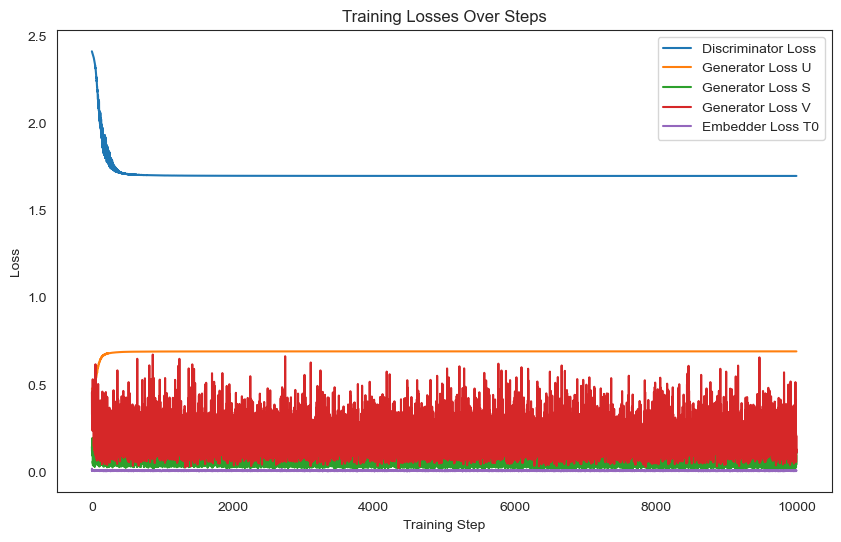

In [439]:
# Initialize TensorBoard writer
writer = SummaryWriter()

# Initialize losses
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0

real_data_list = []
generated_data_list = []
losses = {
    'step_d_loss': [],
    'step_g_loss_u': [],
    'step_g_loss_s': [],
    'step_g_loss_v': [],
    'step_e_loss_t0': []
}

for step in tqdm(range(10000)):

    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(iter(real_batch)).to(device)

        Z_ = next(iter(random_batch)).to(device)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(iter(real_batch)).to(device)

    Z_ = next(iter(random_batch)).to(device)

    step_d_loss = get_discriminator_loss(X_, Z_, gamma)

    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_, gamma)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss.item():6.4f} | g_loss_u: {step_g_loss_u.item():6.4f} | '
                f'g_loss_s: {step_g_loss_s.item():6.4f} | g_loss_v: {step_g_loss_v.item():6.4f} | e_loss_t0: {step_e_loss_t0.item():6.4f}')
    losses['step_d_loss'].append(step_d_loss.item())
    losses['step_g_loss_u'].append(step_g_loss_u.item())
    losses['step_g_loss_s'].append(step_g_loss_s.item())
    losses['step_g_loss_v'].append(step_g_loss_v.item())
    losses['step_e_loss_t0'].append(step_e_loss_t0.item())

    # Log to TensorBoard
    writer.add_scalar('G Loss S', step_g_loss_s.item(), step)
    writer.add_scalar('G Loss U', step_g_loss_u.item(), step)
    writer.add_scalar('G Loss V', step_g_loss_v.item(), step)
    writer.add_scalar('E Loss T0', step_e_loss_t0.item(), step)
    writer.add_scalar('D Loss', step_d_loss.item(), step)

    real_data_list.append(X_.cpu().detach().numpy())
    generated_data_list.append(synthetic_data(Z_).cpu().detach().numpy())

torch.save(synthetic_data, 'time_gan/TimeGAN.pth')

# Close the TensorBoard writer
writer.close()

# Plot the losses
plt.figure(figsize=(10, 6))

# Plot each type of loss
plt.plot(losses['step_d_loss'], label='Discriminator Loss')
plt.plot(losses['step_g_loss_u'], label='Generator Loss U')
plt.plot(losses['step_g_loss_s'], label='Generator Loss S')
plt.plot(losses['step_g_loss_v'], label='Generator Loss V')
plt.plot(losses['step_e_loss_t0'], label='Embedder Loss T0')

plt.title('Training Losses Over Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


In [442]:
generated_data = []

# Loop over the number of batches
for i in range(int(6)):

    Z_ = next(iter(random_batch))  # Assuming random_series is an iterator
    Z_ = torch.tensor(Z_, dtype=torch.float32).to(device)

    # Generate data using the synthetic data model
    with torch.no_grad():  # Disable gradient computation for inference
        d = synthetic_data(Z_)
        print(d.shape)
    # Store the generated data
    generated_data.append(d.cpu().detach().numpy())  # Convert tensor to numpy array


generated_data = np.concatenate(generated_data, axis=0)

torch.Size([6, 2, 11])
torch.Size([6, 2, 11])
torch.Size([6, 2, 11])
torch.Size([6, 2, 11])
torch.Size([6, 2, 11])
torch.Size([6, 2, 11])


C:\Users\vasil\AppData\Local\Temp\ipykernel_8676\1431595677.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z_ = torch.tensor(Z_, dtype=torch.float32).to(device)


11

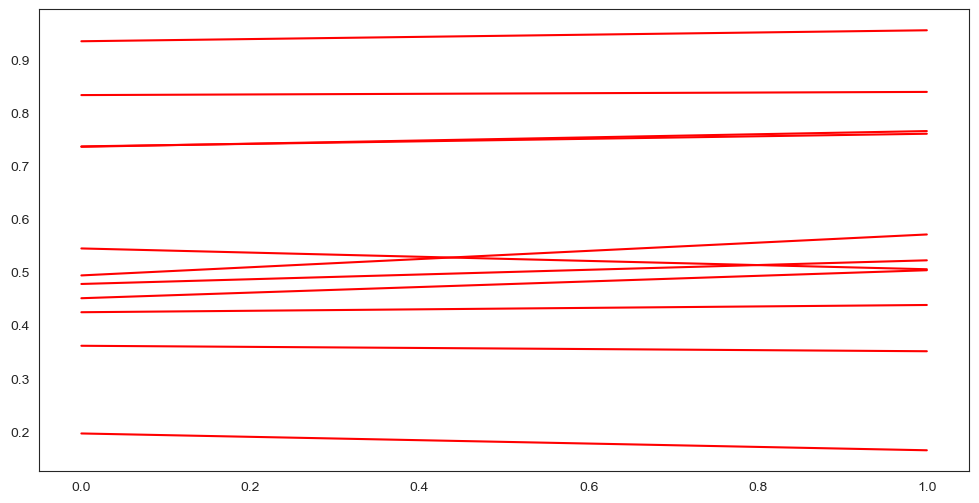

In [443]:
plt.figure(figsize=(12, 6))

# Plot real data

# plt.plot(sc[0], sc[1])


# Plot generated data

plt.plot(generated_data[0],c = 'r')  # Adjust based on your data shape

# plt.plot(generated_data)
# plt.show()
generated_data
len(scaled_data[1])